In [1]:
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8) #0.333
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [2]:
from tensorflow.compat.v1.keras import backend as K
import tensorflow as tf
K.clear_session()
tf.compat.v1.reset_default_graph()
K.get_session()

In [3]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, GlobalMaxPool2D
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalMaxPool3D, GlobalMaxPool2D, GlobalMaxPooling2D, GlobalMaxPooling3D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
#from fr_utils import *
#from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15390723559020526740
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9370284851
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6163427816063353048
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
#check the GPU again
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.4.0


'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [6]:
data_path = os.path.join('/home/sina/Desktop/fruits-360')
train_folder = os.path.join(data_path,'Test')
valpath = os.path.join(data_path,'Training')

In [7]:
base_class_name = 'character'

In [8]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [9]:
classes = gen_class_names(base_class_name)

In [10]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [11]:
labels = generate_one_hot_encoding(classes)

# Siamese Networks

In [12]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

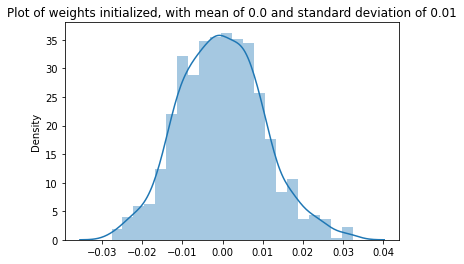

In [13]:
from matplotlib import pyplot as plt

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [14]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

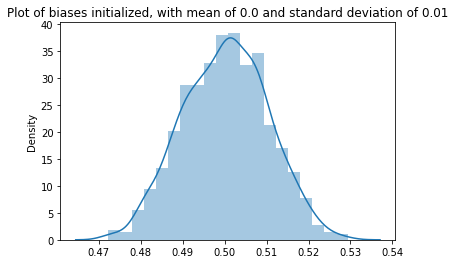

In [15]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [16]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.applications import resnet50, vgg16, vgg19, xception, densenet, inception_v3, mobilenet, nasnet, inception_resnet_v2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.applications import MobileNetV2
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping
from keras.applications.resnet50 import preprocess_input
from keras import optimizers

def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    #model.add(GlobalAveragePooling2D())
    #model.add(Activation('sigmoid', name='predictions'))
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [17]:
#model = get_siamese_model((224, 224, 3))
model = get_siamese_model((100,100,3))
#model = get_siamese_model((100, 100, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         27426112    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]             

In [28]:
#optim = SGD(lr=0.0001, decay=0.0001, momentum=0.9, nesterov=True)
optim = Adam(lr=0.00006)

#compile the network using binary cross entropy loss and the above optimizer
model.compile(loss="binary_crossentropy", optimizer=optim, metrics=['accuracy'])

In [19]:
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Underwater Photography, 20 samples of the Housing category.


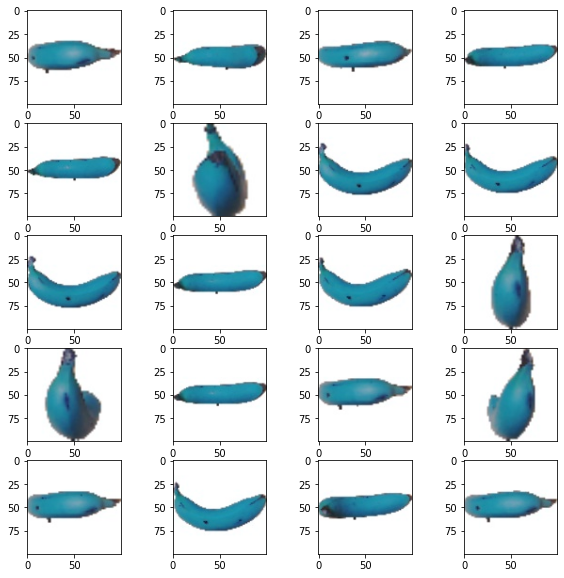

In [21]:
plot_images(os.path.join(data_path, 'Test/Banana'))
print("Underwater Photography, 20 samples of the Housing category.")

Electronics. Computer & Accessories, 20 samples of the CaseFan Category.


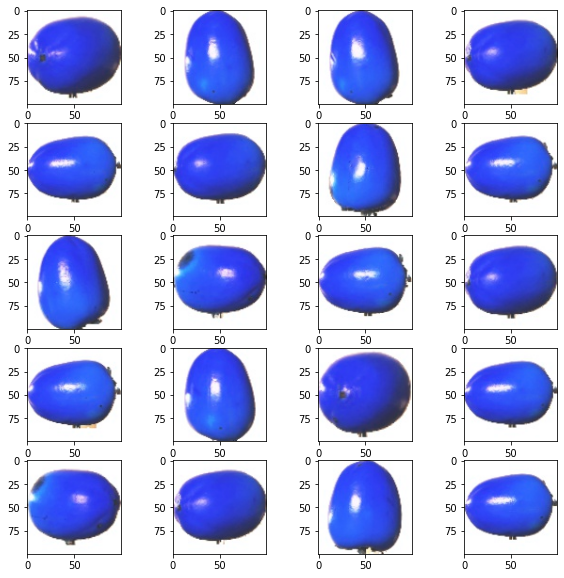

In [22]:
plot_images(os.path.join(data_path, 'Test/Kaki'))
print("Electronics. Computer & Accessories, 20 samples of the CaseFan Category.")

In [23]:
from load_data_Amazon import *

loading Product's Category: Pear Monster
loading Product's Category: Grapefruit Pink
loading Product's Category: Apple Braeburn
loading Product's Category: Cherry Rainier
loading Product's Category: Pear 2
loading Product's Category: Nectarine
loading Product's Category: Melon Piel de Sapo
loading Product's Category: Dates
loading Product's Category: Onion Red
loading Product's Category: Cantaloupe 1
loading Product's Category: Physalis with Husk
loading Product's Category: Pineapple
loading Product's Category: Clementine
loading Product's Category: Cherry 1
loading Product's Category: Cactus fruit
loading Product's Category: Tomato Cherry Red
loading Product's Category: Tamarillo
loading Product's Category: Banana Lady Finger
loading Product's Category: Pitahaya Red
loading Product's Category: Redcurrant
loading Product's Category: Nut Pecan
loading Product's Category: Pomelo Sweetie
loading Product's Category: Cocos
loading Product's Category: Apple Crimson Snow
loading Product's Cat

In [24]:
save_path = '/home/sina/Desktop/data/'
import pickle

with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Training alphabets: \n")
print(list(classes.keys()), end="\n\n")
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Pear Monster', 'Grapefruit Pink', 'Apple Braeburn', 'Cherry Rainier', 'Pear 2', 'Nectarine', 'Melon Piel de Sapo', 'Dates', 'Onion Red', 'Cantaloupe 1', 'Physalis with Husk', 'Pineapple', 'Clementine', 'Cherry 1', 'Cactus fruit', 'Tomato Cherry Red', 'Tamarillo', 'Banana Lady Finger', 'Pitahaya Red', 'Redcurrant', 'Nut Pecan', 'Pomelo Sweetie', 'Cocos', 'Apple Crimson Snow', 'Potato Sweet', 'Pepino', 'Cantaloupe 2', 'Nectarine Flat', 'Cherry Wax Black', 'Tangelo', 'Strawberry Wedge', 'Cherry Wax Yellow', 'Tomato not Ripened', 'Tomato Heart', 'Pepper Red', 'Guava', 'Avocado', 'Corn Husk', 'Rambutan', 'Pear Kaiser', 'Quince', 'Tomato 2', 'Mangostan', 'Lychee', 'Grape Blue', 'Pear Stone', 'Kiwi', 'Raspberry', 'Grape White', 'Physalis', 'Mulberry', 'Onion White', 'Granadilla', 'Ginger Root', 'Cucumber Ripe', 'Nut Forest', 'Kumquats', 'Potato White', 'Apple Red Delicious', 'Grapefruit White', 'Eggplant', 'Walnut', 'Maracuja', 'Hazelnut', 'Apple Granny Smith', 'Mandar

In [25]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                #print("Shape of data loaded from pickle {}".format(X.shape))
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h, u = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w, u)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, u)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, u)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h, u = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        #if language is not None:
            #low, high = self.categories[s][language]
            #print("low {}& high:{}".format(low, high))

            #if N > high - low:
                #raise ValueError("This language ({}) has less than {} letters".format(language, N))
            #categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        #else:#if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:,:]]*N).reshape(N, w, h, u)
        support_set = X[categories,indices,:,:,:]
        support_set[0,:,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h, u)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
            #if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(save_path)

loading data from /home/sina/Desktop/data/train.pickle
loading data from /home/sina/Desktop/data/val.pickle


shape of X:(20, 100, 100, 3)
shape of axs:(5, 4)


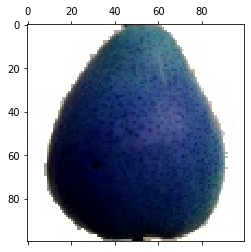

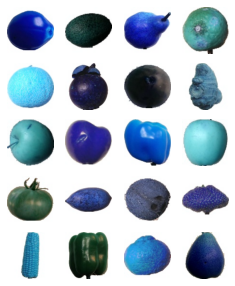

In [26]:

def concat_images(X):
    fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(4, 5))
    print("shape of X:{}".format(X.shape))
    print("shape of axs:{}".format(axs.shape))
    for ax, img in zip(axs.ravel(), X):
        ax.imshow(img)
        ax.axis('off')
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig, ax1 = plt.subplots(1)
    ax1.matshow(pairs[0][1].reshape(100,100,3), cmap='gray')
    ax2 = concat_images(pairs[1])
    #print("shape of ax1:{}".format(type(ax1)))
    #ax1.get_yaxis().set_visible(False)
    #ax1.get_xaxis().set_visible(False)

    #ax2.matshow(img,cmap='gray')
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Cherry Wax Red")
plot_oneshot_task(pairs)

In [30]:

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
weights_path_2 = os.path.join(data_path, "model_weights_color.h5")

print("Starting training process!")
print("-------------------------------------")
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#from keras_input_pipeline import *
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
model.summary()
with tf.device('/gpu:1'):
    t_start = time.time()
    for i in range(1, n_iter):
        (inputs,targets)=loader.get_batch(batch_size)
        loss=model.train_on_batch(inputs,targets)
        #print("\n ------------- \n")
        #print("Loss: {0}".format(loss)) 
        if i % evaluate_every == 0:
            print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
            val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
            if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                #print("Saving weights to: {0} \n".format(weights_path))
                model.save_weights(weights_path_2)
                best=val_acc
        
        if i % loss_every == 0:
            print("iteration {}, training loss: {},".format(i,loss))
            print("\n ---------------------------------------------------- \n")
        
model.load_weights(weights_path_2)

Starting training process!
-------------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         27426112    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)              

# Testing Pipeline

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 99.33333333333333% 3 way one-shot learning accuracy 

Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 99.33333333333333% 5 way one-shot learning accuracy 

Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 99.77777777777777% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 5 way

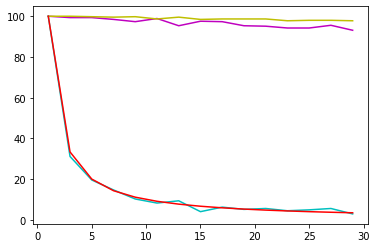

In [31]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

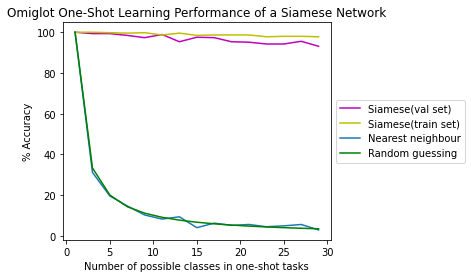

(20, 100, 100, 3)
shape of X:(20, 100, 100, 3)
shape of axs:(5, 4)


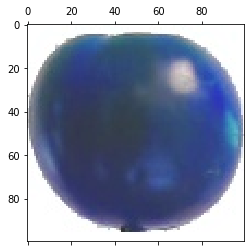

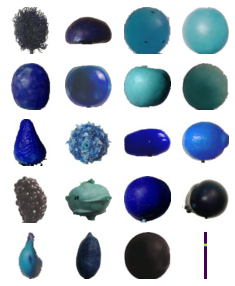

In [32]:
from PIL import Image

fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()
print(inputs[0].shape)
plot_oneshot_task(inputs)
p=model.predict(inputs)
img = plt.imshow(p)
